# Version 5b 
Things changed in this version:
1. More analysis on data and improve model performance [here](https://www.kaggle.com/marto24/beginners-prediction-top3/notebook)
[here](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python)
[here](https://github.com/rnepal2/House-Prices-Data/blob/master/house_price.ipynb)
[here](https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner#Part-0-:-Imports,-Settings,-Functions)
2. Cross Validation.
3. Feature engineering and selection [here](https://www.kaggle.com/solegalli/feature-engineering-and-model-stacking) 
[here](https://www.kaggle.com/dejavu23/house-prices-plotly-pipelines-and-ensembles)

In [434]:
!pip install kaggle
!pip install feature_engine
!pip install category_encoders
!pip install catboost
!pip install shap

In [435]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques --force

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 14.3MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 23.8MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.9MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 59.9MB/s]


In [436]:
!git push train.csv

fatal: not a git repository (or any of the parent directories): .git


In [437]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# !cp train.csv '/content/gdrive/MyDrive/Colab Notebooks'

Note (things learned):
1. Training set: A set of examples used for learning, that is to fit the parameters of the classfier
2. Validation set: A set of examples used to tune the parameters for a classifier, for example to choose the number of hidden units in a neural network, k-fold cross-validation?
3. Test set: A set of examples used only to assess the performance of a fully specific classifier
4. In order to avoid data leakage, it is better to split train.csv to train and validation and do data preprocessing only on train [here](https://stats.stackexchange.com/questions/77350/perform-feature-normalization-before-or-within-model-validation)
5. Apply imputation and normalization to test exactly the same way as on train
6. Stacking Regressor: An ensemble learning technique to combine multiple regression models
7. Model Evaluation (Two Approaches):
- Training/Validation: split data into training, validation and test. Train model on training set and then hyperparameter tunning by validation. Finally test on test set.[here](https://www.researchgate.net/post/should_I_split_the_data_set_into_training_and_testing_or_use_K_cross-validation_for_the_whole_dateset_to_evaluate_the_classification_model)
  - When dataset is large and there might be inherent correlation among data. Need to create independent data for validation  
- Split data into training and test. K-fold cross validation, hyperparameterr tunning on training and then test model on test
  - When dataset is not big enough to be split into training and validation. Use this approach in order to use data as much as possible


Question: 
1. Whether need to impute test set the same way as train? Save a median from training and use it to impute the test set? *Yes*

2. Whether need to normalize test set the same way as training? Save the scale and offest from training data and use on test? *Yes if it is normalization or any other type of transformation that actually learns some parameters from the data. But if using log1p, which is a simple transformation that doesn't use any parameters, it doesn't need to save all the scale [here](https://stats.stackexchange.com/questions/456029/right-way-to-perform-log-transformation-without-data-leakage)*
3. Whether need to drop the highly correlated features for test set exactly the same way as train
4. Whether need to do the same exact preprocessing for test data set as for train? What if there is missing value in test but not in train?
5. Whether to transform back numerical features for interpretation

Todo:
1. Assumptions of various regression model:

Linear Regression Assumptions [here](https://www.jmp.com/en_us/statistics-knowledge-portal/what-is-regression/simple-linear-regression-assumptions.html)
- Linear Relationship: True relationship is linear
- No autocorrelation: Errors are indenpendently 
- Normality: Errors are normally distributed
- Homoscedasticity: Errors have equal variance around the line
- No multicollinearity: Independent variables are not correlated with each other across all observation

2. Data exploration and Feature Engineering [here](https://www.kaggle.com/solegalli/feature-engineering-and-model-stacking) and [here](https://www.kaggle.com/marto24/beginners-prediction-top3/comments)
3. Create a simple data preprocess template 


# 1.1 Read data set and get dimension

In [438]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine import creation
from feature_engine import imputation as imp
from feature_engine import selection as sel
from feature_engine import encoding as enc
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from scipy.stats import norm, skew 
from scipy import stats
from scipy.stats import uniform, truncnorm, randint
import category_encoders as ce
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.cross_decomposition import PLSRegression
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import shap
import pickle
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")



css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [439]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('The numbers of rows in train is %d and number of feature is %d'%(train.shape[0],train.shape[1]))
print('The numbers of rows in test is %d and number of feature is %d'%(test.shape[0],test.shape[1]))

The numbers of rows in train is 1460 and number of feature is 81
The numbers of rows in test is 1459 and number of feature is 80


In [440]:
# The extra column in train is Sales prices
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [441]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [442]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [443]:
test_ID = test['Id']

(1459, 80)

In [444]:
train_target = train['SalePrice']

# 1.2 Check for duplicated ID

In [445]:
num_unique_ID = train.Id.nunique()
num_total_ID = train.shape[0]
num_duplicate_ID = num_total_ID - num_unique_ID
print('The number of duplicated ID in train data set is %d' % num_duplicate_ID)
print('Dropping duplicated IDs ....................')
train.drop_duplicates(['Id'],inplace = True)
print('The number of IDs after drop is %d' %train.Id.nunique())


The number of duplicated ID in train data set is 0
Dropping duplicated IDs ....................
The number of IDs after drop is 1460


# 1.3 Data exploration - missing values 



### 1.3.1 Check for missing values 
Note: Here we check missing values in both train and submission test. But later we will impute just using train information

In [446]:
print('Checking null values')
train = train[train.columns[~train.columns.isin(['SalePrice','Id'])]]
test = test[test.columns[~test.columns.isin(['Id'])]][train.columns]
data = pd.concat([train[train.columns[~train.columns.isin(['SalePrice','Id'])]],test], axis = 0)#check both train and test data set
null = data.isnull().sum()
null = null[null > 0].to_frame()
null.reset_index(inplace=True)
null.columns = ['Feature','number_of_missing']
null['Percentage_of_missing_values'] = null['number_of_missing']/null.shape[0]
null.sort_values(by = ['Percentage_of_missing_values'],ascending = False, inplace=True)
display(null)
print('-' * 70)

Checking null values


,Feature,number_of_missing,Percentage_of_missing_values
30,PoolQC,2909,85.558824
32,MiscFeature,2814,82.764706
2,Alley,2721,80.029412
31,Fence,2348,69.058824
22,FireplaceQu,1420,41.764706
1,LotFrontage,486,14.294118
25,GarageFinish,159,4.676471
28,GarageQual,159,4.676471
29,GarageCond,159,4.676471
24,GarageYrBlt,159,4.676471


----------------------------------------------------------------------


### 1.4.2 Impute categorical features

Categorical Features: From the data description and the above table, we are able to find out the reason of having 159 garage related numbers missing is because the house doesn't have garage. Similarily, the same reason of large missing values in PoolQC, MiscFeature, Alley, Fence, FirplaceQC, Basement related variable, and masonry veneer related variable 

In [447]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities', 'MasVnrType']
#fill in na for those categorical features
# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    data[col].fillna('None',inplace=True)


In [448]:
# Need to use train_cat mode to impute in order to avoid data leakage
#electric_mode = train_cat['Electrical'].mode().values[0]
#cat_data['Electrical'].fillna(electric_mode, inplace=True)

###1.4.3 Impute numerical features

Numerical Features: From the description and the above table, the reason of having missing values in Basement related features is because the house doesn't have a basement. The same reason for missing value in GarageYrBlt and MaxVnrArea

In [449]:
#impute basement related features with 0 
bsmt_feature = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
for i in bsmt_feature:
    data[i].fillna(0, inplace=True)

In [450]:
#impute garage year built with min or the same value as year built
min_GarageYrBlt = data['GarageYrBlt'].min()
data['GarageYrBlt'].fillna(min_GarageYrBlt, inplace=True)
data['GarageCars'].fillna(0, inplace=True)
data['GarageArea'].fillna(0, inplace=True)

In [451]:
data['MasVnrArea'].fillna(0, inplace=True)

LotFrontage imputation: Use linear regression model to predict LotFrontage by LotArea since these two features are highly correlated. Note: Need to use train data to extrapolate the regression line in order to avoid data leakage!

Alternative Approach: normally in the same neighborhood, the lotFrontage is the same. So we can impute LotFrontage using the median within the neighborhood. 


In [452]:
def fillna_lotfrontage(X_train, y_train):

    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    return reg.coef_.tolist()[0], reg.intercept_

In [453]:
#Need to use LotArea to extrapolate the line
LotArea_list = data['LotArea'].dropna()[:1000]
LotArea = [[LotArea_list[i]] for i in range(len(LotArea_list))]
LotFrontAge = data['LotFrontage'].dropna()[:1000]
w, intercept = fillna_lotfrontage(LotArea, LotFrontAge)

for i in range(len(data["LotFrontage"])):
    if list(data['LotFrontage'].isnull())[i]:
        data.loc[data.index[i], "LotFrontage"] = data.loc[data.index[i], "LotArea"]*w + intercept

Double check missing values after imputation and separate train and submission data

In [454]:
print('Checking null values')
null = data.isnull().sum()
null = null[null > 0].to_frame()
null.reset_index(inplace=True)
null.columns = ['Feature','number_of_missing']
null['Percentage_of_missing_values'] = null['number_of_missing']/null.shape[0]
null.sort_values(by = ['Percentage_of_missing_values'],ascending = False, inplace=True)
display(null)
print('-' * 70)

Checking null values


,Feature,number_of_missing,Percentage_of_missing_values


----------------------------------------------------------------------


In [455]:
#split back train and test 
train_row = train.shape[0]
test_row = test.shape[0]

train = data[:train_row]
test = data[train_row:]


# 1.4 Find numerical and categorical features

###1.4.1 Training data set

In [456]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Question: Inside numerical features, there are also some categorical variables. How to identify them? Titan example?

In [457]:
categorical_features = train.select_dtypes(include = ['object']).columns
numerical_features = train.select_dtypes(exclude = ['object']).columns
train_num = train.loc[:,numerical_features]
train_cat = train.loc[:,categorical_features]


print('The number of categorical features in train is %d' % len(categorical_features))
print('The categorical features are :')
print(categorical_features)
print('-'*80)
print('The number of numerical features in train is %d' % len(numerical_features))
print('The numerical features are :')
print(numerical_features)


The number of categorical features in train is 43
The categorical features are :
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
--------------------------------------------------------------------------------
The number of numerical features in train is 36
The numerical features are :
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt',

In [458]:
train_cat.shape

(1460, 43)

In [459]:
train_num.shape

(1460, 36)

### 1.4.2 Test data set

In [460]:
categorical_features = test.select_dtypes(include = ['object']).columns
numerical_features = test.select_dtypes(exclude = ['object']).columns
submission_cat = test.loc[:,categorical_features]
submission_num = test.loc[:,numerical_features]

print('The number of categorical features in submission data is %d' % len(categorical_features))
print('The categorical features are :')
print(categorical_features)
print('-'*80)
print('The number of numerical features in submission data is %d' % len(numerical_features))
print('The numerical features are :')
print(numerical_features)

The number of categorical features in submission data is 43
The categorical features are :
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
--------------------------------------------------------------------------------
The number of numerical features in submission data is 36
The numerical features are :
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',

# 1.5 Split features and target variable

In [461]:
X_train = train
y_train = train_target
print('Train features has %s rows and %s columns' %(X_train.shape[0],X_train.shape[1]))
print('Train target has %s instances' % (len(y_train)))

X_test = test
print('Test features has %s rows and %s columns' %(X_test.shape[0],X_test.shape[1]))

Train features has 1460 rows and 79 columns
Train target has 1460 instances
Test features has 1459 rows and 79 columns


# 1.6 Data Exploration - Explore target variable distribution and test for normality

The Distribution of SalePrice is right skewed

The mean of sales price 180921.20 and standard deviation is 79415.29



((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74160.16474519414, 180921.19589041095, 0.9319665641512983))

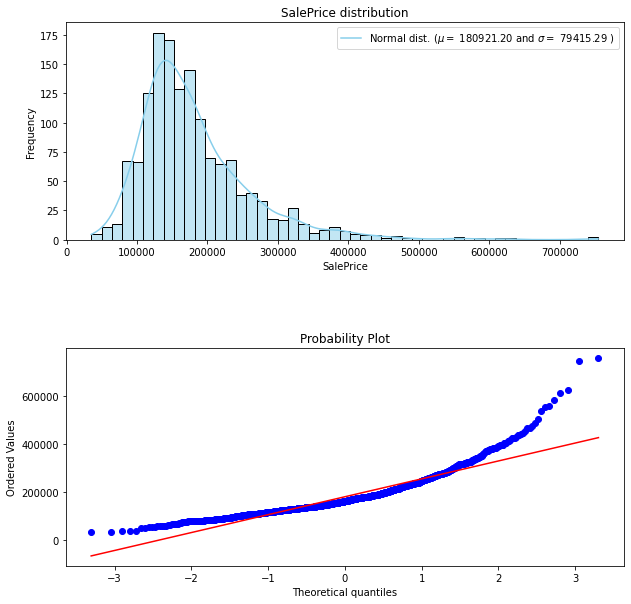

In [462]:
fig, axes = plt.subplots(ncols=1, nrows=2,figsize = (10,10))
fig.subplots_adjust(hspace=0.5)#adjust the vertical space between subplots

#Sals price distribution
#ax = axes[0] let know where to put the plt on the canvas
sns.histplot(data=y_train, kde=True, color="skyblue",ax = axes[0]) 

#Get the parameters 
mu, sigma = norm.fit(y_train)
print( 'The mean of sales price {:.2f} and standard deviation is {:.2f}\n'.format(mu, sigma))
axes[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
axes[0].set_ylabel('Frequency')
axes[0].title.set_text('SalePrice distribution')

#QQ plot
stats.probplot(y_train, plot = plt)



Question: Does linear regression require normally distributed target variable? why is it necessary to log transform target variable?

Answer: No, linear regression doesn't need target variable to be normally distributed. In fact, it is reasonable for the residuals in a regression to be normally distributed while the target variable is not [here](https://stats.stackexchange.com/questions/12262/what-if-residuals-are-normally-distributed-but-y-is-not). 

The reasons to log transform target variable is to first solve for heteroscedasiticity (refer to 'Introduction to Statistical Learning') and transform negative sales prices


The mean of sales price 180921.20 and standard deviation is 79415.29



((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.398259646654151, 12.024057394918403, 0.9953761551826702))

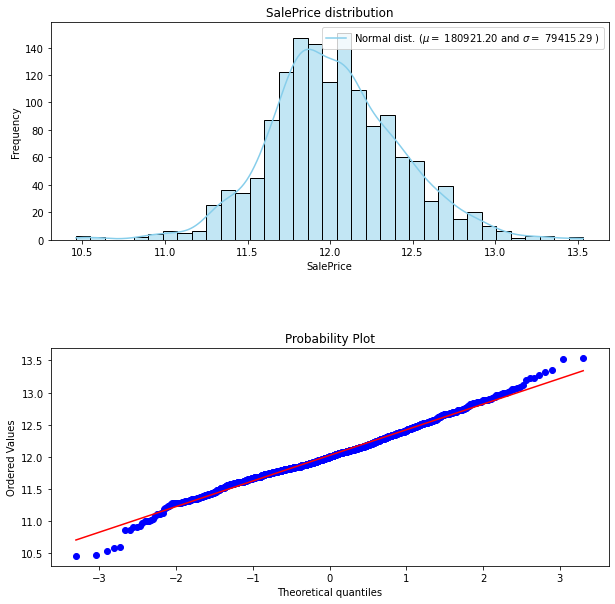

In [463]:
fig, axes = plt.subplots(ncols=1, nrows=2,figsize = (10,10))
fig.subplots_adjust(hspace=0.5)#adjust the vertical space between subplots

#Sales price distribution
#ax = axes[0] let know where to put the plt on the canvas
y_train_transformed = np.log1p(y_train) #log1p()is more accurate for small x
sns.histplot(data=y_train_transformed, kde=True, color="skyblue",ax = axes[0]) 

#Get the parameters 
mu, sigma = norm.fit(y_train)
print( 'The mean of sales price {:.2f} and standard deviation is {:.2f}\n'.format(mu, sigma))
axes[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
axes[0].set_ylabel('Frequency')
axes[0].title.set_text('SalePrice distribution')

#QQ plot
stats.probplot(y_train_transformed, plot = plt)

# 1.7 Data exploration - Correlation 

### 1.7.1 Find correlation among features - Do correlation before normalization since normalize may affect the correlation

Quesion: 
1. Calculate correlation before/after imputation and encoding??
2. How to determine the threshold of the correlation to filter out features?
3. How to filter out correlated CATEGORICAL features? 



From the heatmap below, there are a couple of observations:
1. YearRemodAdd and YearBuilt are highly correlated. I guess for the house which hasn't been remodeled, their year of remodel is the same as year built
2. BsmtUntSF and 1stFlrSF are highly correlated. As mentioned earlier, we can drop one of them
3. All the garage related features are highly correlated. As mentioned earlier, we can transform these features

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

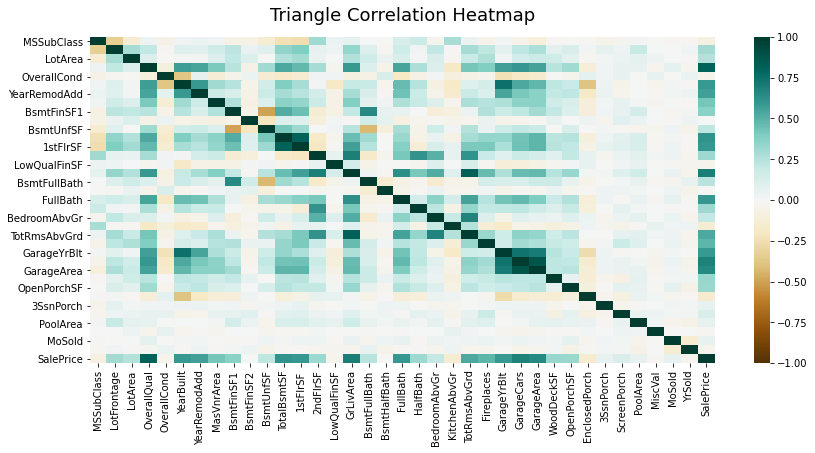

In [464]:
# Find the most correlated numerical features
# The correlation matrix completely ignore cateogical variables
corr_train = pd.concat([X_train,y_train_transformed], axis=1)
corr_matrix = corr_train.corr()
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot= False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

Let's zoom in to find the features with high correlation with each other

There are 17 of numerical features with correlation larger than 0.5
The top correlated numerical features are below
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice'],
      dtype='object')


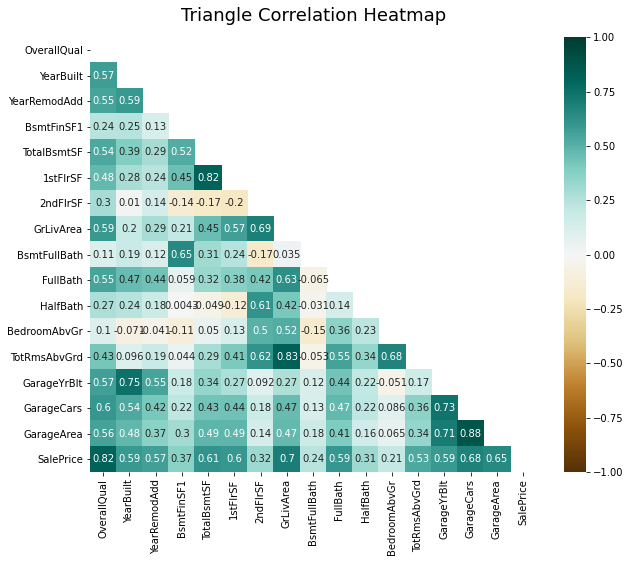

In [465]:
# Find the most correlated numerical features
# The correlation matrix completely ignore cateogical variables
plt.figure(figsize=(10, 8))
top_feature = (corr_matrix.mask(np.eye(len(corr_matrix), dtype=bool)).abs() > 0.5).any()
top_feature_corr = corr_matrix.loc[top_feature, top_feature]
mask = np.triu(np.ones_like(top_feature_corr, dtype=np.bool))
heatmap = sns.heatmap(top_feature_corr, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
print('There are %s of numerical features with correlation larger than 0.5'%(top_feature_corr.shape[0]))
print('The top correlated numerical features are below')
print(top_feature_corr.columns)

### 1.7.2 Observations and thoughts

Most of the features which are highly correlated with target features are also correlated with each other. This may raise the issue of multilinearity. But we don't want to drop them, which may result in information loss. We will do feature transformation/combination to solve for this issue. 

### 1.7.3 Explore the relationship between features vs. Sales Price one by one

overallQual vs. sales price - overallqual and sales price has really clear positive relationship

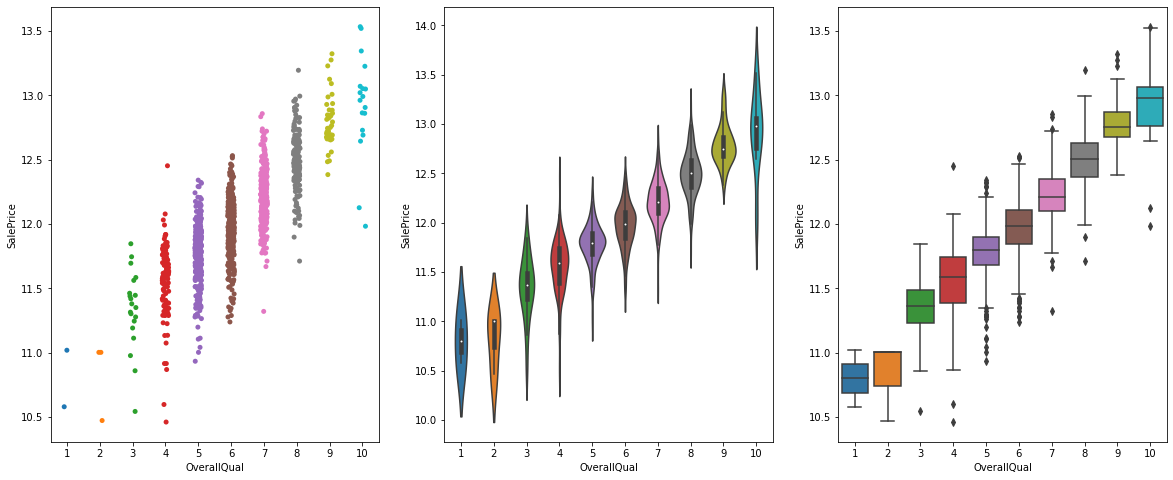

In [466]:
#overallQual has the larget correlation with the target variable
#overallQual is a variable with integers from 1 to 10 indicating different levels of quality
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(X_train.OverallQual, x = 'OverallQual', y=y_train_transformed, ax = ax[0])
sns.violinplot(X_train.OverallQual, x = 'OverallQual', y=y_train_transformed, ax = ax[1])
sns.boxplot(X_train.OverallQual, x = 'OverallQual', y=y_train_transformed, ax = ax[2])
plt.show()

GrLivArea and TotRmsAbvGrd vs. Salesprice - Above ground living area has strong positive relationship with sales price. However, they are also correlated with each other. Need to explore more and transform those those features or keep only one of them in order to avoid multlinearity

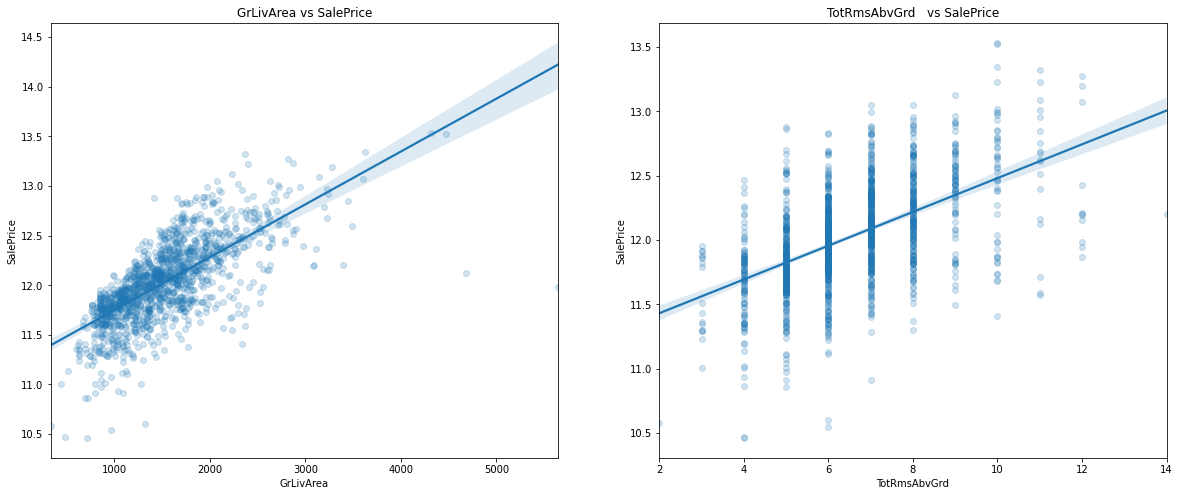

In [467]:
figure, axes = plt.subplots(1,2, figsize = (20,8))
sns.regplot(X_train['GrLivArea'], x = 'GrLivArea', y=y_train_transformed, scatter_kws={'alpha':0.2}, ax = axes[0])
axes[0].title.set_text('GrLivArea vs SalePrice')

sns.regplot(X_train['TotRmsAbvGrd'] , x = 'TotRmsAbvGrd', y=y_train_transformed, scatter_kws={'alpha':0.2}, ax = axes[1])
axes[1].title.set_text('TotRmsAbvGrd   vs SalePrice')

plt.show()

Garage cars and garage area - They also have strong positive relationship with sales price. However, they are also highly correlated with each other. Need to explore more and transform those those features or keep only one of them in order to avoid multlinearity

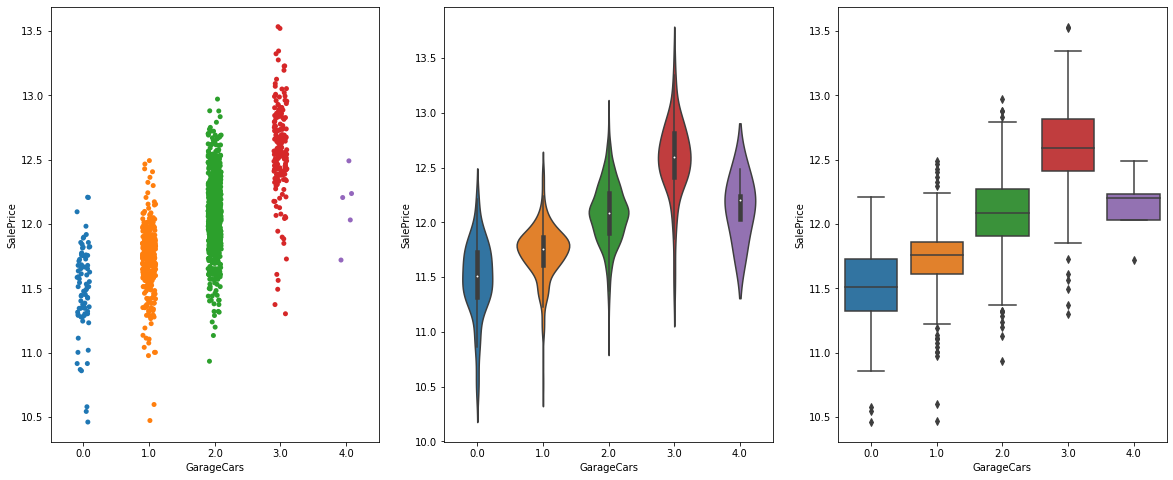

In [468]:
figure, ax = plt.subplots(1,3, figsize = (20,8))
sns.stripplot(X_train.GarageCars, x = 'GarageCars', y=y_train_transformed, ax = ax[0])
sns.violinplot(X_train.GarageCars, x = 'GarageCars', y=y_train_transformed, ax = ax[1])
sns.boxplot(X_train.GarageCars, x = 'GarageCars', y=y_train_transformed, ax = ax[2])
plt.show()

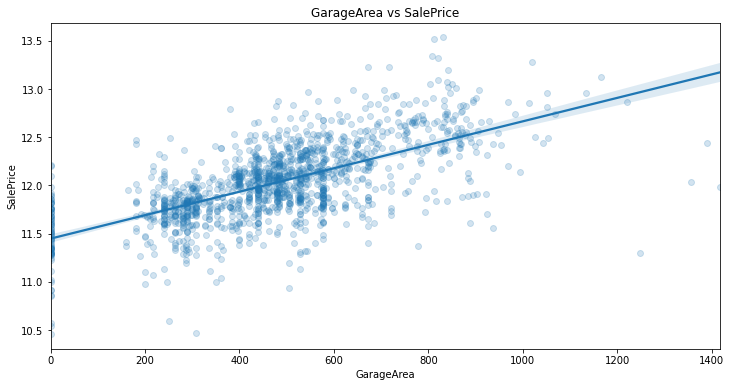

In [469]:
plt.figure(figsize = (12,6))
sns.regplot(X_train.GarageArea, x = 'GarageArea', y=y_train_transformed, scatter_kws={'alpha':0.2})
plt.title('GarageArea vs SalePrice', fontsize = 12)
plt.show()

TotalBsmtSF&1stFlrSF - They have strong positive relationship with sales price. Similarily, they are also correlated with each other. Need to explore more and transform those those features or keep only one of them in order to avoid multlinearity

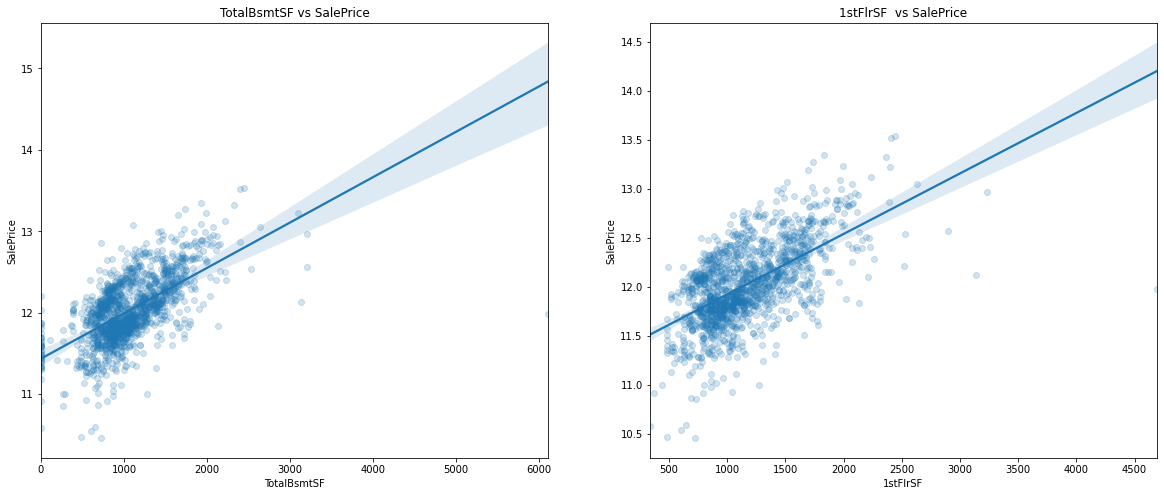

In [470]:
figure, axes = plt.subplots(1,2, figsize = (20,8))
sns.regplot(X_train['TotalBsmtSF'], x = 'TotalBsmtSF', y=y_train_transformed, scatter_kws={'alpha':0.2}, ax = axes[0])
axes[0].title.set_text('TotalBsmtSF vs SalePrice')

sns.regplot(X_train['1stFlrSF'] , x = '1stFlrSF', y=y_train_transformed, scatter_kws={'alpha':0.2}, ax = axes[1])
axes[1].title.set_text('1stFlrSF  vs SalePrice')

plt.show()

YearBuilt vs. Sales price - There is a tendency between these two features. Newer house tend to have higher price than old house. But we don't know whether this salesprice is normalized after inflation

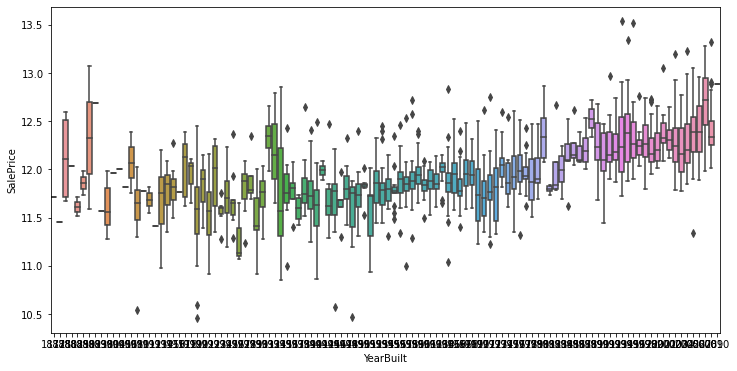

In [471]:
plt.figure(figsize = (12,6))
sns.boxplot(X_train.YearBuilt, x = 'YearBuilt', y=y_train_transformed)
plt.show()

### 1.7.4 New features
The combination of features may based on some intuition and the understanding of features.

New Features:

1. Area_per_car: GarageArea/GarageCars
2. AbvGrdRms: TotRmsAbvGrd + FullBath + HalfBath + KitchenAbvGr + BedroomAbvGr
3. BsmtBath: BsmtFullBath + BsmtHalfBath 
4. All_Liv_SF: TotalBsmtSF + 1stFlrSF + 2ndFlrSF
5. YrSoldToBuilt: YrSold - YearBuilt;
   YrSoldToRemod: YrSold - YearRemodAdd;
   YrSoldToGarage: YrSold - GarageYrBlt


Features to drop:
1. TotRmsAbvGrd
2. 1stFlrSF
3. 2ndFlrSF
4. TotalBsmtSF
5. GarageCars
6. BsmtFullBath
7. BsmtHalfBath
8. All year related feature


Question: Whether to drop the original features even if we combine them?
Answer: The hierarchical principle ('Introduction to Statistical Learning') states that even if we include an interaction in a model, we should also include the main effects

In [472]:
def new_feature(df):
    #Area_per_car
    df['Area_per_car'] = np.where(df['GarageCars'] == 0, 0, df['GarageArea']/df['GarageCars'])
    #AbvGrdRms
    df['AbvGrdRms'] = df['TotRmsAbvGrd'] + df['FullBath']+ df['HalfBath'] + df['KitchenAbvGr'] + df['BedroomAbvGr']
    #BsmtBath
    df['BsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath']
    #All_Liv_SF
    df['All_Liv_SF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    return df


In [473]:
X_train = new_feature(X_train)
X_test = new_feature(X_test)

### 1.7.5 Drop features

In [474]:
def drop_feature(df):
    feature_to_drop = ['TotRmsAbvGrd','1stFlrSF','2ndFlrSF','TotalBsmtSF',\
                       'GarageCars','BsmtFullBath','BsmtHalfBath']
    df.drop(feature_to_drop, inplace = True, axis = 1)
    return df

X_train = drop_feature(X_train)
X_test = drop_feature(X_test)


#1.8 Data Exploration - Find outliers

Scatter plot of top correlated features

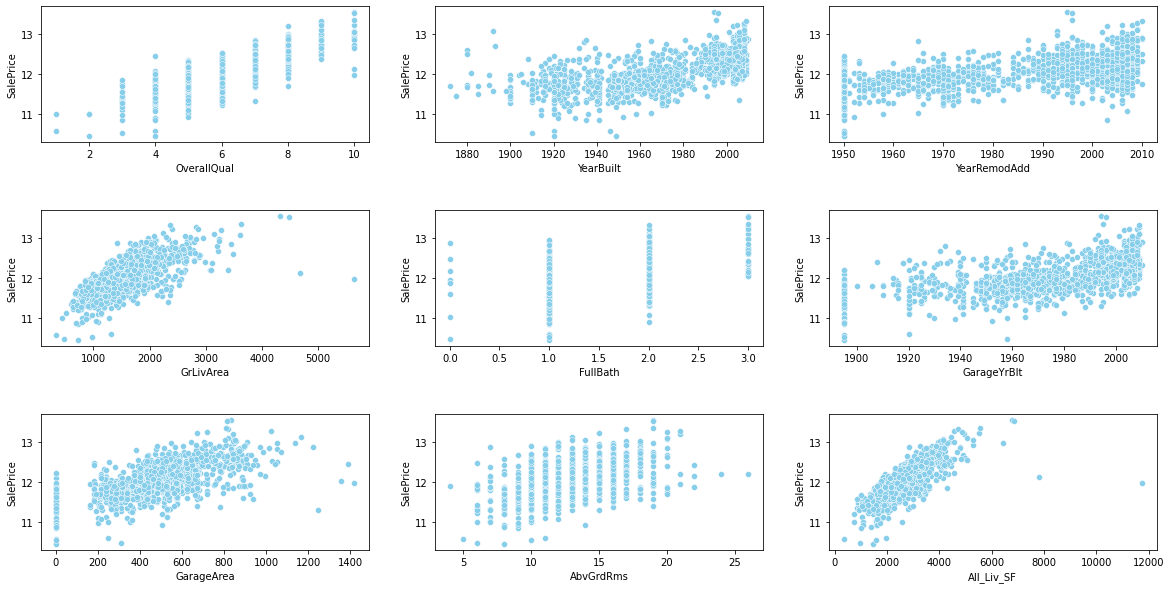

In [475]:
corr_train = pd.concat([X_train,y_train_transformed], axis=1)
corr_matrix = corr_train.corr()
top_feature = corr_matrix.index[abs(corr_matrix["SalePrice"])>0.5].drop('SalePrice')
top_feature_corr = corr_matrix.loc[top_feature, top_feature]
fig, axes = plt.subplots(ncols=3, nrows=3,figsize = (20,10))#adjust size of the subplot canvas
fig.subplots_adjust(hspace=0.5)#adjust the vertical space between subplots
for i, ax in zip(range(0,len(list(top_feature_corr.columns))), axes.flat):
    feature = list(top_feature_corr.columns)[i]
    sns.scatterplot(data=X_train, x=feature, y = y_train_transformed, color="skyblue", ax=ax)

#1.7 Data Exploration - Find feature distribution and test for normality




###1.7.1 Calculate skewness all features

Question: If there is a null value, calculate skewness ignoring the null value or should perform imputation before calculate skewness?

Answer: Normality test (which ignores null values) or Shapiro-Wilk test (which cannot ignore null values)

In [476]:
categorical_features = X_train.select_dtypes(include = ['object']).columns
numerical_features = X_train.select_dtypes(exclude = ['object']).columns
train_num = X_train.loc[:,numerical_features]
train_cat = X_train.loc[:,categorical_features]

skewness = train_num.apply(lambda x: skew(x,nan_policy = 'omit')) #ignore na value
skewness.sort_values(ascending=False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
EnclosedPorch     3.086696
LotFrontage       2.823998
MasVnrArea        2.674865
OpenPorchSF       2.361912
All_Liv_SF        1.774874
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
MSSubClass        1.406210
GrLivArea         1.365156
BsmtUnfSF         0.919323
OverallCond       0.692355
HalfBath          0.675203
Fireplaces        0.648898
AbvGrdRms         0.491944
BsmtBath          0.477105
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
YrSold            0.096170
FullBath          0.036524
Area_per_car     -0.082407
YearRemodAdd     -0.503044
YearBuilt        -0.612831
GarageYrBlt      -0.982280
dtype: float64

Most of the features are skewed to the right and have different scale

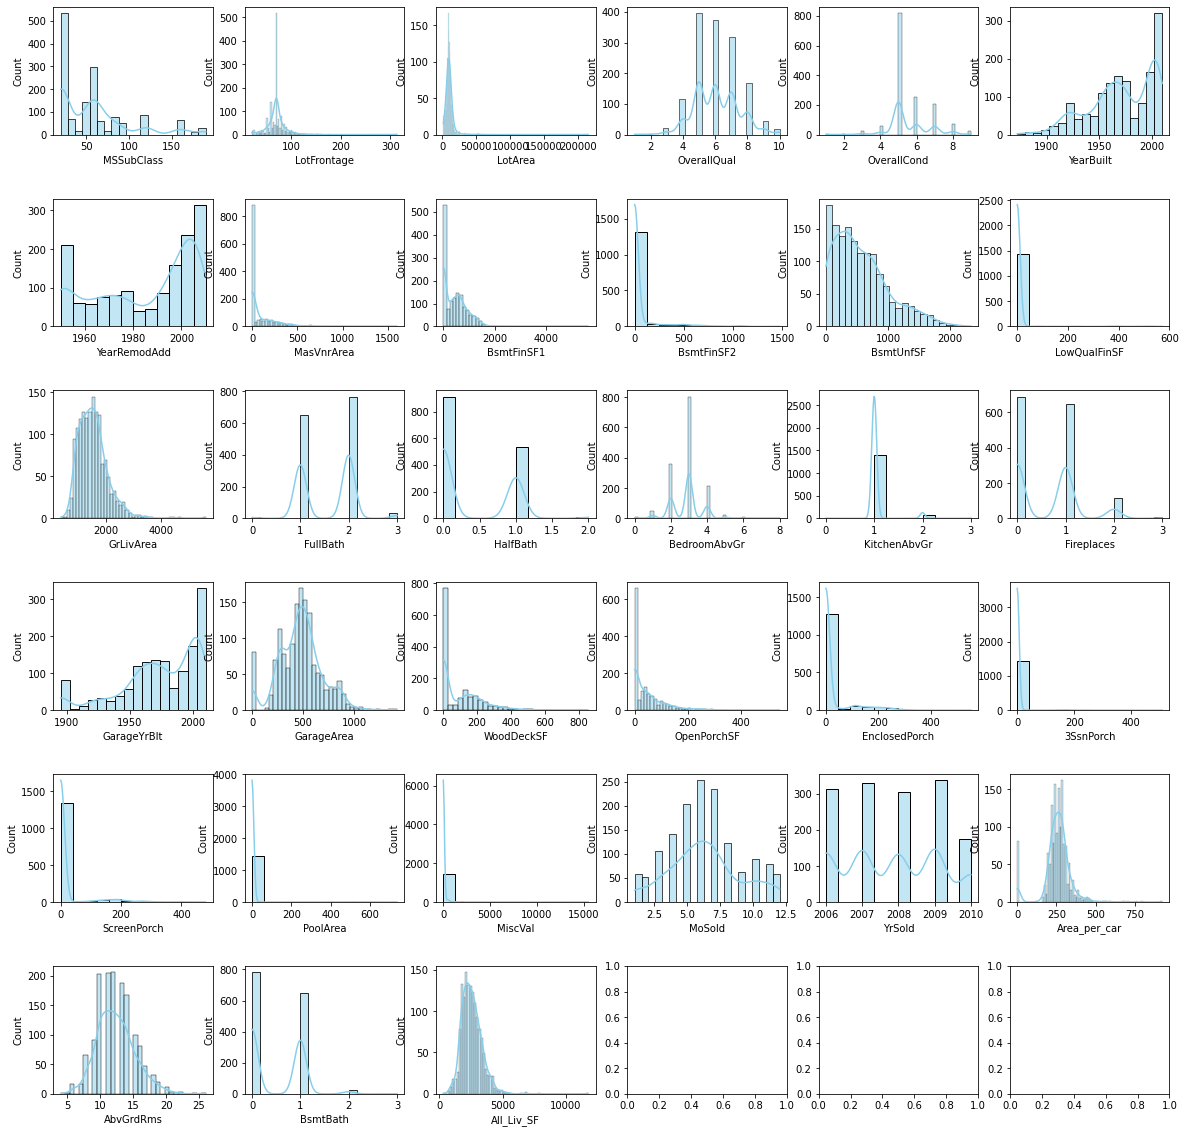

In [477]:
fig, axes = plt.subplots(ncols=6, nrows=6,figsize = (20,20))#adjust size of the subplot canvas
fig.subplots_adjust(hspace=0.5)#adjust the vertical space between subplots
for i, ax in zip(range(0,len(list(train_num.columns))), axes.flat):
    feature=train_num.columns[i]
    sns.histplot(data=train_num, x=feature, kde=True, color="skyblue", ax=ax)

### 1.7.2 Test normality of the numerical features 

All features are not normally distributed and most of them are right skewed (refer above). They are also on different scale. So we may need to either scale them or log transform them, which will do in the pipeline

Different ways to test normality:
- Distribution plot (shown above)
- QQ plot
- Normality test (which ignores null values) or Shapiro-Wilk test (which cannot ignore null values)

Question: Does linear regression assume the features to be normally distributed (multivariate normal)?

Answer: No. But need to scale the features if features are from different scale. 
But linear regression does assume residuals to be independently normally distributed. So we need to conduct normality check of errors after modeling


In [478]:
statistics_list = []
p_value_list = []

for i in range(0,len(list(train_num.columns))):
    feature=train_num.columns[i]
    stat,p_value = stats.normaltest(train_num[feature],nan_policy = 'omit')#ignore na value
    statistics_list.append(stat)
    p_value_list.append(p_value)

normality_test = pd.DataFrame(columns = ['Feature','Test-statistics','P_value','Decision'])
normality_test['Feature'] = list(train_num.columns)
normality_test['Test-statistics'] = statistics_list
normality_test['P_value'] = p_value_list
normality_test['Decision'] = np.where(normality_test['P_value'] > 0.5, 'Normal','Not Normal')
normality_test

,Feature,Test-statistics,P_value,Decision
0,MSSubClass,337.186618,6.037486e-74,Not Normal
1,LotFrontage,1068.662962,8.765693e-233,Not Normal
2,LotArea,2590.591868,0.000000e+00,Not Normal
3,OverallQual,11.904564,2.599901e-03,Not Normal
4,OverallCond,131.291777,3.092807e-29,Not Normal
5,YearBuilt,98.332028,4.440905e-22,Not Normal
6,YearRemodAdd,2431.493630,0.000000e+00,Not Normal
7,MasVnrArea,865.134368,1.375494e-188,Not Normal
8,BsmtFinSF1,638.286564,2.499388e-139,Not Normal
9,BsmtFinSF2,1287.443707,2.723649e-280,Not Normal


# 1.9 Design data preprocessing pipeline

In [479]:
reg_pipeline = Pipeline([
    
    # === feature creation ===
    
    # this transformer substracts the reference variables from YrSold, 
    # one at a time, to create 3 new variables with the elapsed time between the 2
    ('elapsed_time', creation.CombineWithReferenceFeature(
        variables_to_combine = ['YrSold'],
        reference_variables = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'],
        operations=['sub'],
        new_variables_names = ['YrSoldToBuilt', 'YrSoldToRemod','YrSoldToGarage']
    )),
    
    # === drop year vars ===
    # now that I have used these variables to derive the above features, I
    # drop them from the data
    ('drop_features', sel.DropFeatures(
        features_to_drop =['YearBuilt', 'YearRemodAdd', 'GarageYrBlt','YrSold']
        #features_to_drop =['YearBuilt', 'YearRemodAdd', 'GarageYrBlt','YrSold',\
        #                   'BsmtFullBath', 'BsmtHalfBath','1stFlrSF', '2ndFlrSF',\
        #                   'TotRmsAbvGrd', 'FullBath','HalfBath', 'KitchenAbvGr']
    )),

    # === categorical encoding 

    # one hot encoding of the 10 most frequent categories of each categorical
    # variable
    # (Feature-engine recognises categorical variables automatically if they 
    # are casted as object) 
    ('encoder', enc.OneHotEncoder(top_categories=10)),
     
    # === feature Scaling ===
    
    ('scaler', StandardScaler()),
])

### 1.9.1 Fit data preprocessing pipeline on train and test

In [480]:
# fit pipeline, learns all necessary parameters
reg_pipeline.fit(X_train, y_train_transformed)

# transform the train and test data
X_train_linear = reg_pipeline.transform(X_train)
X_test_linear = reg_pipeline.transform(X_test)

#2.0 Modeling
- Lasso Regression - L1 regularization
- Ridge Regression - L2 regularization
#### L1 norm vs. L2 norm [here](https://www.kaggle.com/residentmario/l1-norms-versus-l2-norms)

- BayesianRidge Regression
- XGBoost Regression
- Light Gradient Boost Regression
- GradientBoost Regression
- Cat Boost Regression
- Stacked Regression
- Support Vector Regression
- Decision Tree Regression
- Random Forest Regression
- Stacked Regression
- Partial Least Squares Regression
- Principal Component Regression

# 2.1 Linear Regression



### 2.1.1 Fit the model using cross validation and hyperparameter tuning on number of features. [reference](https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression)

In [489]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 40))}]

# step-3: perform grid search by RFE
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train_linear, y_train_transformed)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
best_model = model_cv.fit(X_train_linear, y_train_transformed)                  

Fitting 5 folds for each of 39 candidates, totalling 195 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed: 16.4min finished


In [490]:
best_model.best_estimator_.get_params()
print('The best cross validate train MSE is ',(-best_model.best_score_))

The best cross validate train MSE is  0.14257477498578716


# 2.2 Ridge Regression and Lasso Regression - Use Regularization

### 2.2.1 Ridge Regression and hyperparameter tuning
 

In [491]:
ridge_params = [{'alpha': list(np.linspace(1,40,40))}]
ridge = Ridge()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
ridge_cv = GridSearchCV(estimator = ridge, 
                        param_grid = ridge_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  
    
# fit the model
best_ridge = ridge_cv.fit(X_train_linear, y_train_transformed) 
best_ridge.best_estimator_.get_params()
print('The best cross validate train MSE is ',(-best_ridge.best_score_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best cross validate train MSE is  0.024986615687364523


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.8s finished


### 2.3.1 Lasso Regression and hyperparamter tuning

In [492]:
lasso_params = [{'alpha': list(np.linspace(0.001,0.003,100))}]
lasso_reg = Lasso()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
lasso_cv = GridSearchCV(estimator = lasso_reg, 
                        param_grid = lasso_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)  
    
# fit the model
best_lasso = lasso_cv.fit(X_train_linear, y_train_transformed) 
best_lasso.best_estimator_.get_params()
print('The best cross validate train MSE is ',(-best_lasso.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best cross validate train MSE is  0.022719593956090314


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   26.7s finished


# 2.3 Principal Components Regression
[reference](https://www.statology.org/principal-components-regression-in-python/)

We can see that as we adding more principal components, cross validate MSE will decrease. However, MSE starts to increase after components reach to 40-ish. That means, after this threshold, the principle component we add into the model does not have too much explain power. So to be simple, let's choose components to be 47

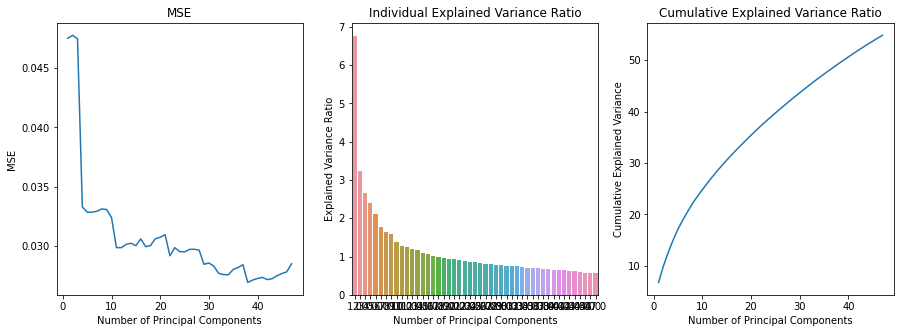

In [493]:
n_components = 47
pca = PCA(n_components)
X_transformed = pca.fit_transform(X_train_linear)
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
regr = LinearRegression()
mse = []
num_component = np.linspace(1,n_components,n_components)
for i in range(1,len(num_component)+1):
    score = -1*cross_val_score(regr,X_transformed[:,:i], y_train_transformed, cv=folds, scoring='neg_mean_squared_error').mean()
    mse.append(score)

explained_variance = list(np.round(pca.explained_variance_ratio_, decimals=4)*100)
pca_df = pd.DataFrame(columns = ['Number of the Principal Components',\
                                 'Cross Validate MSE', 'Explained Variance Ratio',\
                                 'Cumulative Explained Variance Ratio'])
pca_df['Number of the Principal Components'] = list(num_component)
pca_df['Cross Validate MSE'] = mse
pca_df['Explained Variance Ratio'] = explained_variance
pca_df['Cumulative Explained Variance Ratio'] = list(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))


fig, axes = plt.subplots(ncols=3, nrows=1,figsize = (15,5))
sns.lineplot(data = pca_df, x = 'Number of the Principal Components', y = 'Cross Validate MSE', ax = axes[0])
axes[0].set_xlabel('Number of Principal Components')
axes[0].set_ylabel('MSE')
axes[0].title.set_text('MSE')

sns.barplot(data = pca_df, x = 'Number of the Principal Components', y = 'Explained Variance Ratio', ax = axes[1])
axes[1].set_xlabel('Number of Principal Components')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].title.set_text('Individual Explained Variance Ratio')

sns.lineplot(data = pca_df, x = 'Number of the Principal Components', y = 'Cumulative Explained Variance Ratio', ax = axes[2])
axes[2].set_xlabel('Number of Principal Components')
axes[2].set_ylabel('Cumulative Explained Variance')
axes[2].title.set_text('Cumulative Explained Variance Ratio')


#pca_df


Apply 37 principal components on test data and see how it performs. MAE of test data is better than the one in 2.1.2, indicating a small improvment

In [496]:
n_components = 37
pca = PCA(n_components)
pca.fit(X_train_linear)
X_train_transformed = pca.transform(X_train_linear)

regr = LinearRegression()
regr.fit(X_train_transformed,y_train_transformed)

kf = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(regr, X_train_transformed, y_train_transformed, \
                            scoring='neg_mean_squared_error', cv=kf)

print('The average cross validate train MSE is ',(-scores.mean()))


The average cross validate train MSE is  0.028152705427905083


# 2.4 Partial Least Squared Regression

In [497]:
pls_params = [{'n_components': list(np.linspace(1,60,60,dtype=np.int))}]
pls_reg = PLSRegression()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
pls_cv = GridSearchCV(estimator = pls_reg, 
                      param_grid = pls_params, 
                      scoring= 'neg_mean_squared_error', 
                      cv = folds, 
                      verbose = 1,
                      return_train_score=True)  
    
# fit the model
best_pls = pls_cv.fit(X_train_linear, y_train_transformed) 
best_pls.best_estimator_.get_params()
print('The best cross validate train MSE is ',(-best_pls.best_score_))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best cross validate train MSE is  0.02465897942248121


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   31.4s finished


# 2.5 Summary of Using Linear Regression
Based on the analysis above, I first fit 263 features to linear regression which gives me a bad overfit issue. Then I tried a couple of approaches to solve for the overfit. The first approach is using regularization. Then I tried PCA and PLS regression, which both improve the overfit issue. The best model is using PCA Regression with MSE at 0.025786. In the next section, I will explore machine learning approach

# 2.6 Random Forest Regression

In [498]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

rfr_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfr_reg = RandomForestRegressor()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
rfr_cv = RandomizedSearchCV(estimator = rfr_reg, 
                      param_distributions = rfr_params, 
                      scoring= 'neg_mean_squared_error', 
                      cv = folds,
                      n_iter = 50, 
                      verbose = 1,
                      return_train_score=True)  

# fit the model
best_rfr = rfr_cv.fit(X_train_linear, y_train_transformed)
print('The best parameters are below') 
print(best_rfr.best_estimator_.get_params())
rfr_score = -best_rfr.best_score_
print('The best cross validate train MSE is ',(rfr_score))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.9min finished


The best parameters are below
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 90, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
The best cross validate train MSE is  0.020747358505056594


# 2.7 Decision Tree Regression

In [499]:
criterion= ['mse', 'mae']
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

dtr_params = {'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
dtr_reg = DecisionTreeRegressor()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
dtr_cv = RandomizedSearchCV(estimator = dtr_reg, 
                      param_distributions = dtr_params, 
                      scoring= 'neg_mean_squared_error', 
                      cv = folds,
                      n_iter = 50, 
                      verbose = 1,
                      return_train_score=True)  

# fit the model
best_dtr = dtr_cv.fit(X_train_linear, y_train_transformed) 
print('The best parameters are below')
print(best_dtr.best_estimator_.get_params())
dtr_score = -best_dtr.best_score_
print('The best cross validate train MSE is ',(dtr_score))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   35.0s finished


The best parameters are below
{'ccp_alpha': 0.0, 'criterion': 'mae', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}
The best cross validate train MSE is  0.0331167713061966


#2.8 Gradient Boost Regression

In [500]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
#criterion
criterion = ['friedman_mse','mse']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

gbr_params = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gbr_reg = GradientBoostingRegressor()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
gbr_cv = RandomizedSearchCV(estimator = gbr_reg, 
                      param_distributions = gbr_params, 
                      scoring= 'neg_mean_squared_error', 
                      cv = folds,
                      n_iter = 50, 
                      verbose = 1,
                      return_train_score=True)  

# fit the model
best_gbr = gbr_cv.fit(X_train_linear, y_train_transformed)
print('The best parameters are below')
print(best_gbr.best_estimator_.get_params())
gbr_score = -best_gbr.best_score_
print('The best cross validate train MSE is ',(gbr_score))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.0min finished


The best parameters are below
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
The best cross validate train MSE is  0.017698278832669702


#2.9 XGBoost Regression

In [501]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
#criterion
criterion = ['friedman_mse','mse']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 15, num = 4)]
max_depth.append(None)
# Minimum weight in the leaf node for further partition
min_weight_fraction_leaf = [int(x) for x in np.linspace(start = 0, stop = 1, num = 10)]
# Regularization - L1 norm
alpha = [0, 0.2, 0.4]


xgb_params = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_weight_fraction_leaf': min_weight_fraction_leaf,
               'alpha': alpha}
xgb_reg = GradientBoostingRegressor()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
xgb_cv = RandomizedSearchCV(estimator = xgb_reg, 
                      param_distributions = xgb_params, 
                      scoring= 'neg_mean_squared_error', 
                      cv = folds,
                      n_iter = 50, 
                      verbose = 1,
                      return_train_score=True)  

# fit the model
best_xgb = xgb_cv.fit(X_train_linear, y_train_transformed)
print('The best parameters are below')
print(best_xgb.best_estimator_.get_params())
xgb_score = -best_xgb.best_score_
print('The best cross validate train MSE is ',(xgb_score))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.5min finished


The best parameters are below
{'alpha': 0.4, 'ccp_alpha': 0.0, 'criterion': 'mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 80, 'n_iter_no_change': None, 'presort': 'deprecated', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
The best cross validate train MSE is  0.01770874532165515


# 3.0 Support Vector Regression

In [ ]:
svr_reg = SVR()
svr_reg.get_params

<bound method BaseEstimator.get_params of SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)>

In [502]:
kernel = ["poly",'rbf']
#regularization
C = [0.053677105521141605, 0.1]
epsilon = [int(x) for x in np.linspace(0.1, 0.3, num = 5)]
coef0 = [int(x) for x in np.linspace(0, 0.5, num = 5)]

svr_params = {'kernel': kernel,
               'C': C,
               'epsilon': epsilon,
               'coef0': coef0}
svr_reg = SVR()

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
svr_cv = RandomizedSearchCV(estimator = svr_reg, 
                      param_distributions = svr_params, 
                      scoring= 'neg_mean_squared_error', 
                      cv = folds,
                      n_iter = 50, 
                      verbose = 1,
                      return_train_score=True)  

# fit the model
best_svr = svr_cv.fit(X_train_linear, y_train_transformed)
print('The best parameters are below')
print(best_svr.best_estimator_.get_params())
svr_score = -best_svr.best_score_
print('The best cross validate train MSE is ',(svr_score))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  5.7min finished


The best parameters are below
{'C': 0.1, 'cache_size': 200, 'coef0': 0, 'degree': 3, 'epsilon': 0, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
The best cross validate train MSE is  0.043686842388330246


# 3.1 Stack Regression
Use the ensemble learning to combine various variable together [Reference](https://analyticsindiamag.com/stackingcvregressor-in-python/)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.9min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   20.2s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.8min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.0min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.4min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.8min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.3min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.3min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.6min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.6min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.7min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.4min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   17.2s finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.7min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.6min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.7min finished


The mean-squared-error on the test data:  0.017372549077425768
The R-squared of the fit on the test data:  0.887563080689808


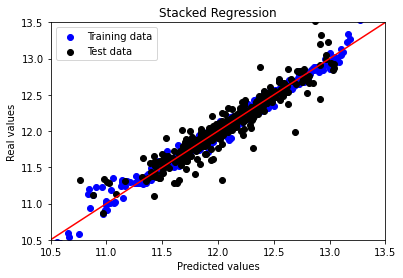

In [ ]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
stack = StackingCVRegressor(regressors=(best_rfr, best_dtr, best_gbr, best_xgb, \
                                        best_svr),
                                meta_regressor=best_xgb, cv=folds,
                                use_features_in_secondary=True,
                                store_train_meta_features=True,
                                shuffle=False)
# fit the model
best_stack = stack.fit(X_train_linear, np.array(y_train_transformed).reshape(1,-1))
best_stack.best_score_
#make_prediction(best_stack, X_train_linear, y_train_transformed, X_test_linear, y_test_transformed, 'Stacked Regression')


# 3.2 Summary of using machine learning regressions
I have built multiple machine learning-based regressions and use hyperparameter tuning to find the best hyperparameter. The best performed model is Gradient Boost with the lowest test MSE at 0.01769 and the second best model is random forest with MSE at 0.01771.

#3.3 Test model on test data set and make prediction

In [507]:
test_pre = best_xgb.predict(np.array(X_test_linear))
test_pre = np.expm1(test_pre)
test['SalePrice'] = list(test_pre)
test['Id'] = list(test_ID)

In [508]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Area_per_car,AbvGrdRms,BsmtBath,All_Liv_SF,SalePrice,Id
0,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,GasA,TA,Y,SBrkr,0,896,1,0,2,1,TA,Typ,0,None,Attchd,1961.0,Unf,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal,730.0,9,0.0,1778.0,127517.696499,1461
1,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,GasA,TA,Y,SBrkr,0,1329,1,1,3,1,Gd,Typ,0,None,Attchd,1958.0,Unf,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal,312.0,12,0.0,2658.0,159208.285952,1462
2,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,GasA,Gd,Y,SBrkr,0,1629,2,1,3,1,TA,Typ,1,TA,Attchd,1997.0,Fin,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal,241.0,13,0.0,2557.0,180448.676236,1463
3,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,GasA,Ex,Y,SBrkr,0,1604,2,1,3,1,Gd,Typ,1,Gd,Attchd,1998.0,Fin,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal,235.0,14,0.0,2530.0,193697.999301,1464
4,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,GasA,Ex,Y,SBrkr,0,1280,2,0,2,1,Gd,Typ,0,None,Attchd,1992.0,RFn,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal,253.0,10,0.0,2560.0,193487.059114,1465


In [510]:
test[['Id','SalePrice']].to_csv("result.csv", index = False, header = True)

# To be Continue: 
3.4 Feature Importance and Interpretation

Question:
1. How to access feature names in pipeline? 
[Answer](https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer)


### 3.4.1 SHAP Feature Importance Summary Plot



In [ ]:
#Get top most important features
def top_features(model, num_feature,X_test, y_test):

    fig = plt.figure(figsize=(18, 10))
    
    #Create Feature importance MDI (Marginal Distribution Importance)
    feature_importance = model.best_estimator_.feature_importances_
    sorted_idx1 = np.argsort(feature_importance)#order in an order of ascending importance
    pos = np.arange(num_feature) + .5  
    plt.subplot(1,2,1)
    plt.barh(pos, list(feature_importance[sorted_idx1])[-num_feature:], align='center')
    plt.yticks(pos,list(X_test.keys()[sorted_idx1])[-num_feature:])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance (MDI)')
    
    #Create Permutation Importance plot
    result = permutation_importance(model, X_test, y_test, n_repeats=10,\
                                random_state=42, n_jobs=2)
    sorted_idx2 = result.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(result.importances[sorted_idx2][-num_feature:].T,
           vert=False, labels=list(X_test_transformed.keys()[sorted_idx2])[-num_feature:])
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()


    #save feature importance table
    feature_importance_table = pd.DataFrame({"Feature": list(X_test.keys()[sorted_idx1])[-num_feature:],\
                                "Importance": list(feature_importance[sorted_idx1])[-num_feature:]})
    feature_importance_table.sort_values(by = ['Importance'],ascending = False,inplace = True)
    return feature_importance_table

AttributeError: ignored

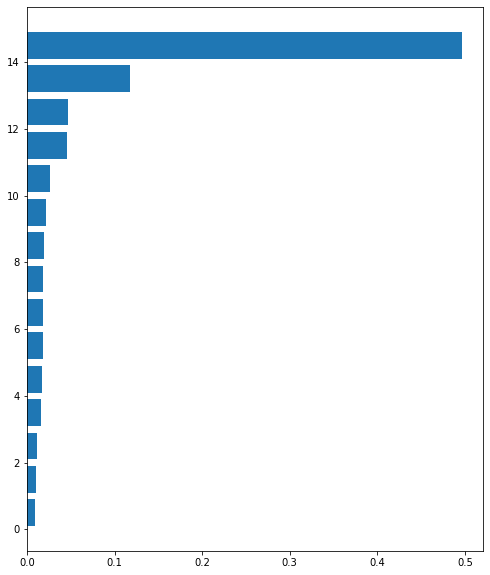

In [ ]:
feature_importance_table = top_features(best_xgb,15,X_test_linear,y_test_transformed)
feature_importance_table

In [ ]:
X_test_linear

array([[-0.86887966,  1.71775678,  2.14850443, ..., -0.10430876,
        12.04159458, -0.05425922],
       [-0.1569649 , -0.13210604, -0.10479696, ..., -0.10430876,
        -0.08304548, -0.05425922],
       [-0.1569649 ,  1.71775678, -0.34540965, ..., -0.10430876,
        -0.08304548, -0.05425922],
       ...,
       [-0.86887966,  0.19921267, -0.01273223, ..., -0.10430876,
        -0.08304548, -0.05425922],
       [-0.86887966, -0.46342476, -0.07388187, ..., -0.10430876,
        -0.08304548, -0.05425922],
       [-0.86887966,  0.44770171,  0.22856099, ..., -0.10430876,
        -0.08304548, -0.05425922]])

###3.4.2 SHAP Feature Importance Force Plot

In [ ]:
#If it is linear model, use shap.LinearExplainer(regr)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_linear) 
shap.initjs()
#The plot represents the 10th observation from test data
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test_linear.iloc[0,:])

#base value is average prediction of all instances from X_test data
#f(x) is the current instance prediction




Exception: ignored

In [ ]:
#If using aggregated of 200 observation from test data
explainer = shap.TreeExplainer(GBM_Reg)
shap_values = explainer.shap_values(X_test_linear) 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_test_linear.iloc[:200,:])


###3.4.3 SHAP Feature Importance Summary Plot

In [ ]:
shap.summary_plot(shap_values, X_test_linear)